# 💻 Welcome to *puncc* API tutorial

In this tutorial, we will see an alternative way to define conformal predictors using *puncc*'s API. We will apply such approach on the diabetes regression problem explored in the [**introduction tutorial**](puncc_intro.ipynb)</font> <sub> [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TC_BM7JaEYtBIq6yuYB5U4cJjeg71Tch) </sub>. 

By the end of this notebook, you will have an overview of *puncc*'s API and can start building your own conformal predictors !


**Table of contents**

- [💾 Reminder: split conformal regression on the diabetes dataset](#scp)
- [💻 The API](#cc)
    - [Calibrator](#calibrator)
    - [Splitter](#splitter)
    - [Conformalization](#conformalization)


**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

## 💾 Reminder: split conformal regression on the diabetes dataset <a class="anchor" id="scp"></a>  

The dataset contains information about 442 diabetes patients. The goal is predict from physiological variables a quantitative measure of disease progression in one year. From all the available features, we keep only the body mass index and train a linear regression to predict the target.

The dataset is split into three subsets:

* Fit subset ${\cal D_{fit}}$ to train the model.
* Calibration subset ${\cal D_{calib}}$ on which nonconformity scores are
  computed.
* Test subset ${\cal D_{test}}$ on which the prediction intervals are
  estimated.

In [1]:
import numpy as np 
from sklearn import datasets
from sklearn import linear_model

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only BMI feature
diabetes_X = diabetes_X[:, 2, np.newaxis]

# Split the data into training/testing sets
X_train = diabetes_X[:-100]
X_test = diabetes_X[-100:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-100]
y_test = diabetes_y[-100:]

# Split fit and calibration data
X_fit, X_calib = X_train[:-100], X_train[-100:]
y_fit, y_calib = y_train[:-100], y_train[-100:]

The linear regression model from scikit-learn is wrapped by deel.puncc.api.prediction.BasePredictor to standardize its interface:

In [2]:
from deel.puncc.api.prediction import BasePredictor

# Create linear regression model
lin_reg_model = linear_model.LinearRegression()

# Create a predictor to wrap the linear regression model defined earlier
# The argument `is_trained` is set to False such that the linear model needs to be
# trained before the calibration. You can initialize it to True if the model is
# already trained and you want to save time.
lin_reg_predictor =  BasePredictor(lin_reg_model, is_trained=False)

Finally, we construct the prediction intervals throught the split conformal prediction method provided by the class `deel.puncc.regression.SplitCP`:

In [3]:
from deel.puncc.regression import SplitCP

# Coverage target is 1-alpha = 90%
alpha=.1

# Instanciate the split cp wrapper around the linear predictor.
split_cp = SplitCP(lin_reg_predictor)

# Train model (if argument `is_train` is False) on the fitting dataset and
# compute the residuals on the calibration dataset. 
split_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)

## Alternatively, we can randomly select the fit/calib subsets as below 
# split_cp.fit(X=X_train, y=y_train, fit_ratio=.8)

# The `predict` returns the output of the linear model `y_pred` and
# the calibrated interval [`y_pred_lower`, `y_pred_upper`].
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 211.38


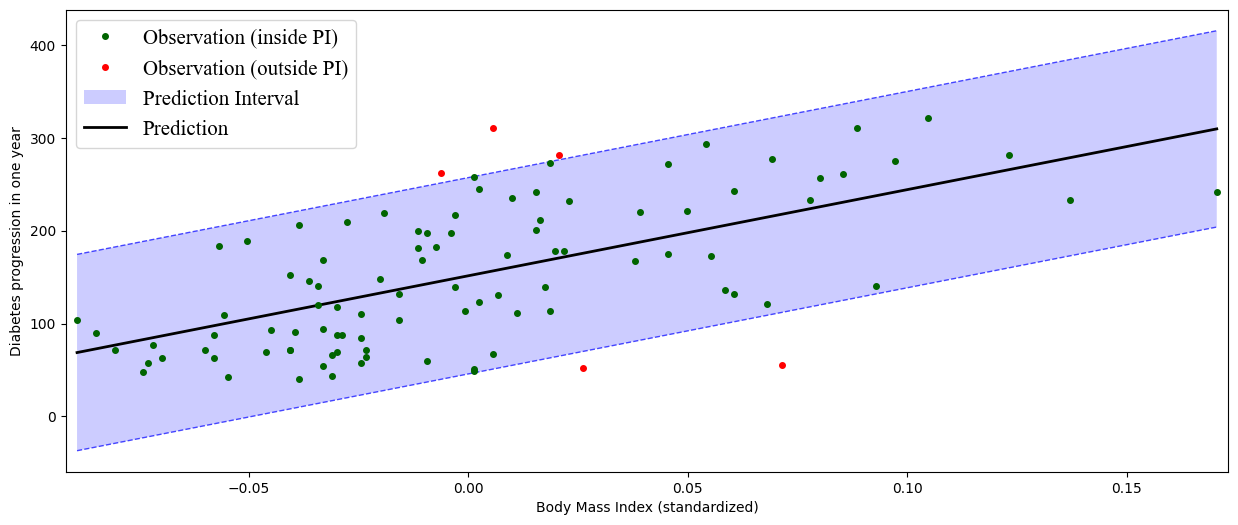

In [4]:
from deel.puncc import metrics
from deel.puncc.plotting import plot_prediction_intervals

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {coverage:.2f}")
print(f"Average width: {width:.2f}")


# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

_ = ax.set_xlabel("Body Mass Index (standardized)")
_ = ax.set_ylabel("Diabetes progression in one year")

## 💻 The API

We now define the **same split conformal prediction** procedure using the *puncc*'s API. Also, we showcase how flexible such approach is by tweaking some of its components.

### Calibrator <a class="anchor" id="calibrator"></a>  

The calibrator instance provides a way of estimating the nonconformity scores on the calibration set and how to compute the prediction sets. For the split conformal prediction procedure, the `BaseCalibrator` uses the mean absolute deviation as nonconformity score and and prediction set are built as constant intervals. These two functions are already provided in `deel.puncc.api.nonconformity_scores.absolute_difference` and `deel.puncc.api.prediction_sets.constant_interval`, respectively. Alternatively, one can define custom functions and pass them as arguments to the calibrator. 

In [5]:
from deel.puncc.api.calibration import BaseCalibrator
from deel.puncc.api import nonconformity_scores
from deel.puncc.api import prediction_sets

## Calibrator construction
my_calibrator = BaseCalibrator(nonconf_score_func=nonconformity_scores.absolute_difference,
                               pred_set_func=prediction_sets.constant_interval)

The `BaseCalibrator` below is similar to the previous one, except it integrates custom nonconformity score (`my_ncf`) and prediction set (`my_psf`) functions:

In [6]:
## Definition of a custom nonconformity scores function.
## Alternatively, several ready-to-use nonconf scores are provided in
## the module deel.puncc.nonconformity_scores
def my_ncf(y_pred, y_true):
    return np.abs(y_pred-y_true)

## Definition of a custom function to build prediction sets.
## Alternatively, several ready-to-use procedure are provided in
## the module deel.puncc.prediction_sets
def my_psf(y_pred, scores_quantile):
    y_lower = y_pred - scores_quantile
    y_upper = y_pred + scores_quantile
    return y_lower, y_upper

## Calibrator construction
my_calibrator = BaseCalibrator(nonconf_score_func=my_ncf,
                               pred_set_func=my_psf)

### Splitter <a class="anchor" id="splitter"></a>  

In **split conformal prediction**, we can either use a deterministic or a random procedure to split the data into fit and calibration.
As we already separated the two subsets, we use the IdSplitter that wraps the data and produces iterables accordingly to **puncc**'s framework: 

In [7]:
from deel.puncc.api.splitting import IdSplitter, RandomSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)

## Alternatively, we can randomly select the fit/calib sets as below 
# fit_ratio = .8
# random_splitter = RandomSplitter(X, y, ratio=fit_ratio, random_state=0)

### Conformalization <a class="anchor" id="conformalization"></a>  

The split **conformal predictor** assembles the previously defined **predictor**, **calibrator** and **splitter** in a specific process to provide prediction intervals with a guaranteed coverage rate: 

In [8]:
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)

# Instanciate a conformal prediction object
split_cp = ConformalPredictor(predictor=lin_reg_predictor, 
                              calibrator=my_calibrator, 
                              splitter=id_splitter,
                              train=True)

# Fit model and compute nonconformity scores
split_cp.fit(X_train, y_train)

# infer prediction interval w.r.t the level risk alpha
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 211.38


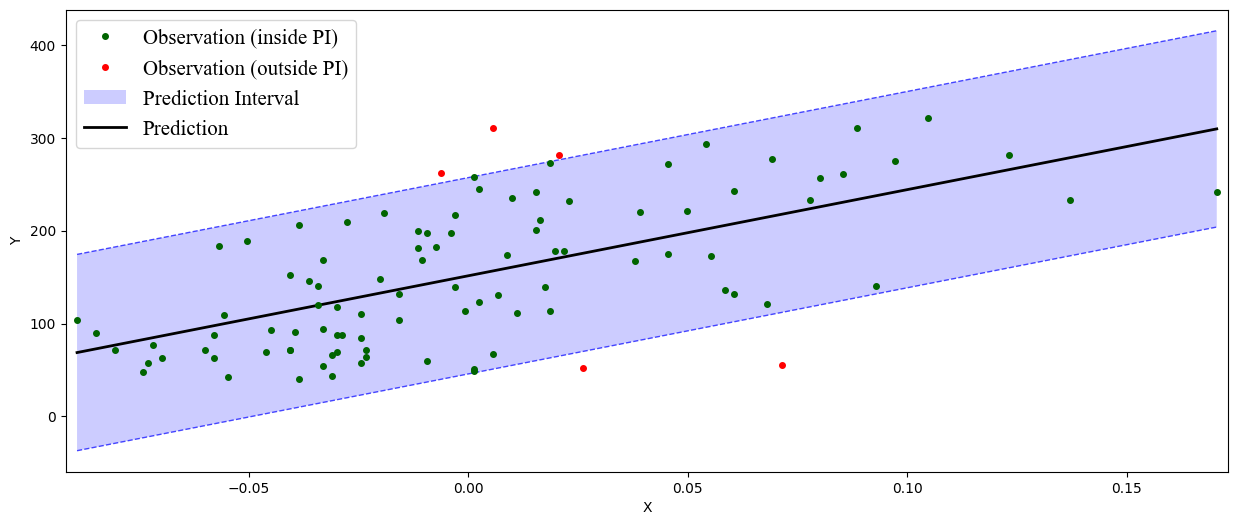

In [9]:
from deel.puncc import metrics
from deel.puncc.plotting import plot_prediction_intervals

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

As such, we obtain the same results as in the high-level API. Notice that we have a conservative prediction interval, because the obtained empirical coverage is larger than the target.

Now let's try to have a tighter enveloppe by modifying the split plan into a K-fold. This is simply done by changing the splitter argument in the `ConformalPredictor` constructor:

In [10]:
from deel.puncc.api.splitting import KFoldSplitter

# 20-fold data splitter
kfold_splitter = KFoldSplitter(K=20, random_state=0)

# Only the splitter argument is changed from before
cv_cp = ConformalPredictor(predictor=lin_reg_predictor, 
                           calibrator=my_calibrator, 
                           splitter=kfold_splitter,
                           train=True)

cv_cp.fit(X_train, y_train)

y_pred, y_pred_lower, y_pred_upper = cv_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.94
Average width: 209.81


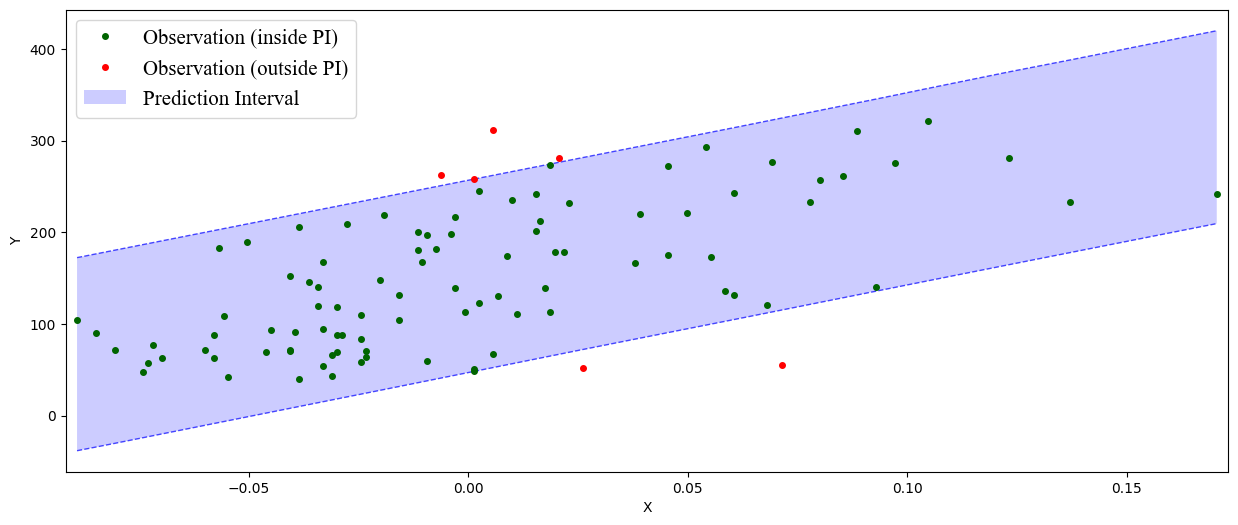

In [11]:
# Compute marginal coverage and average width of the prediction intervals
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

# 🎉 Congratulations
**You are now familiar with *puncc*'s API and can start building your own conformal predictors !**

For more information about *puncc*'s architecture, check [**this notebook**](puncc_architecture.ipynb).